

## Feature Engineering

We will add some more features.

In [27]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox, boxcox1p

# supress unnecessary warnings for readability and cleaner presentation
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

In [28]:
# reading data
df_train = pd.read_csv('use_case_data.csv')
df_score = pd.read_csv('score_data.csv')

df_train['data_type'] = 'train'
df_score['data_type'] = 'score'

In [29]:
# helper function which performs all steps of data processing which we applied during 
# Data cleaning and preprocessing
def prepare_data():
    
    # removing negative market shares
    temp = df_train[df_train['Market_Share'] >= 0]
    
    # applying boxcox
    market_share = stats.boxcox(temp['Market_Share'].values + 1e-30, lmbda=0.25)
    
    # combining train and score
    data = pd.concat([temp.drop(columns='Market_Share'), df_score],ignore_index=True)
    
    # adding response variable
    data['Market_Share'] = np.nan
    mask = data['data_type'] == 'train'
    data.loc[mask, 'Market_Share'] = market_share
    data.drop(columns='data_type', inplace=True)
    
    # changing dtype to category
    data['ITEMSCODE'] = data['ITEMSCODE'].astype('category')

    # spliting to year and month, adding to not_useful_features list
    data['LAUNCH_YEAR'], data['LAUNCH_MONTH'] = data['NPLLAUNCHDATE'].map(str).apply(
        lambda x: [x[:4], x[4:]]).str   
    
    # removing not useful features
    not_useful = ['BRMID', 'LATESTPERIODINDEX', 'NPLLAUNCHDATE', 'ISREPLACEMENT', 'BRM', 'MARKETEDBRAND',
                  'BRANDSUBFAMILY', 'NPLLAUNCHYEAR', 'RTYPE', 'ITEMSHAPE']
    
    data.drop(columns=not_useful, inplace=True)
    
    # filling missing values
    data['SPECIALFLAVOR'].fillna('NOSPECIALFLAVOR', inplace=True)
    data['TIPCOLOR'].fillna('NOTIPCOLOR', inplace=True)
    
    # transform categorical features into the appropriate type
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            data[c] = data[c].astype('category')
            
    data[['LEN', 'NCON', 'RETAILPACKPRICE', 'TRCONTE']] = boxcox1p(data[['LEN', 'NCON', 'RETAILPACKPRICE', 'TRCONTE']], -0.3)
    
    print('all data shape: {}'.format(data.shape))
    return data

We will add some more features by aggregating some categorical features by numeric ones.

For example, we will calculate **mean, median, mode, std, skew** of **RETAILPACKPRICE** for each **REGION**. 

In [91]:
def aggregate(data, f_1, f_2):
    """Aggregates f_1 by f_2"""

    mean_ = '{}_{}_mean'.format(f_1, f_2)
    median_ = '{}_{}_median'.format(f_1, f_2)
    std_ = '{}_{}_std'.format(f_1, f_2)
    mode_ = '{}_{}_mode'.format(f_1, f_2)
    skew_ = '{}_{}_skew'.format(f_1, f_2)
    min_ = '{}_{}_min'.format(f_1, f_2)
    max_ = '{}_{}_max'.format(f_1, f_2)

    temp = data.groupby(f_1)[f_2].aggregate(
        {mean_: np.mean,
         std_: np.std,
         median_: np.median,
         min_: np.min,
         max_: np.max,
         mode_: lambda x: stats.mode(x)[0][0],
         skew_: stats.skew}
    ).reset_index()

    for x in (mean_, std_, median_, mode_, skew_):
        temp[x].fillna(0, inplace=True)

    data = data.merge(temp)
    
    # adding relative (for example product RETAILPACKPRICE / REGION mean RETAILPACKPRICE)
    relative_mean_ = '{}_{}_relative_mean'.format(f_1, f_2)
    relative_median_ = '{}_{}_relative_median'.format(f_1, f_2)
    relative_max_ = '{}_{}_relative_max'.format(f_1, f_2)
    
    def relative(row, f):
        f_value, f_2_value = row[f], row[f_2]
        if f_value == 0 and f_2_value == 0:
            return 1.
        elif f_value == 0 and f_2_value != 0:
            return 1e6
        else:
            return f_2_value / f_value
        
#     data[relative_mean_] = data.apply(lambda row: relative(row, mean_), axis=1)
    data[relative_median_] = data.apply(lambda row: relative(row, median_), axis=1)
#     data[relative_max_] = data.apply(lambda row: relative(row, max_), axis=1)
    return data

In [92]:
def get_final_data(data, to_dummy=False, cardinality_ratio=1.):
    """
    Recives cleaned and preprocessed data, add features, high cardinality features and makes one-hot encoding.
    """
    data_copy = data.copy()

    # removing high cardinality categorical features
    if cardinality_ratio < 1.:
        n = len(data_copy)
        high_cardinalty_features = []
        for c in data_copy.columns:
            if data_copy[c].dtype.name == 'category' and len(data_copy[c].unique()) / n > cardinality_ratio:
                high_cardinalty_features.append(c)
        print('Removing {} features, which have high cardinality.'.format(high_cardinalty_features))
        data_copy.drop(columns=high_cardinalty_features, inplace=True)

    to_be_aggregated = ('REGION', 'BLDIMAGE', 'INDICATOR', 'INTERNATIONALINDICATOR',
                        'ISSTRATEGIC',  'LENCATEGORY', 'MINDICATOR',
                        'PCKT', 'TCLASS', 'THICATEGORY', 'MARKET')

    for f_1 in to_be_aggregated:
        for f_2 in numeric_fs:
            data_copy = aggregate(data_copy, f_1, f_2)

    print('all data shape after features addition: {}'.format(data_copy.shape))

    # one-hot encoding for categorical features
    if to_dummy:
        data_copy = pd.get_dummies(data_copy)
        print('all data shape after one-hot-encoding: {}'.format(data_copy.shape))

    # splitting into train and score
    mask = data_copy['Market_Share'].notnull()
    training_data, score_data = data_copy[mask], data_copy[np.invert(mask)]
    score_data.drop(columns='Market_Share', inplace=True)
    print('training data shape: {}, score data shape: {}'.format(
        training_data.shape, score_data.shape))
    return training_data, score_data

## Evaluation metrics

In [93]:
import itertools
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split
from tabulate import tabulate

In [94]:
def plot_confusion_matrix(matrix, classes, cmap=plt.cm.Reds):
    """This function plots the normalized confusion matrix."""
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title('Normalized Confusion matrix', fontsize=17)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]),range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center", fontsize=17,
                 color="blue" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()
    

def plot_model_performance(y_true, y_pred, matrix):
    """
    This function plots:
        - predicted values vs actual values
        - confusion matrix
        - roc curve
    """
    print()
    
    # plotting predicted values vs actual ones
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_pred)
    plt.title('Actual values vs Predicted values.')
    plt.ylabel('Predicted', fontsize=12)
    plt.xlabel('Actual', fontsize=12)
    plt.show()
              
    print()
    
    # plotting confusion matrix
    plot_confusion_matrix(matrix, ['Failure', 'Success'])
    
    print()
    threshold = 0.007
    threshold_transformed = stats.boxcox(threshold, 0.25)
    binary_target = y_true > threshold_transformed
    
    fpr, tpr, _ = roc_curve(binary_target, y_pred)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, lw=3, alpha=0.3, label='ROC (AUC = %0.2f)' % (auc_score))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [95]:
def scorer(y_true, y_pred):
    """Calculates differnt merics for evaluating our models."""

    threshold = 0.007
    threshold_transformed = stats.boxcox(threshold, 0.25)

    binary_prediction = y_pred > threshold_transformed
    binary_target = y_true > threshold_transformed

    """Regression metrics"""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    explained_variance = explained_variance_score(y_true, y_pred)
    r_2 = r2_score(y_true, y_pred)

    """Classification metrics"""

    # The probability that the model ranks a random
    # positive example more highly than a random negative example.
    auc = roc_auc_score(binary_target, y_pred)

    conf_matrix = confusion_matrix(binary_target, binary_prediction)
    # true positives (TP): We predicted Y and they do have the disease.
    # true negatives (TN): We predicted N, and they don't have the disease.
    # false positives (FP): We predicted Y, but they don't have the disease.
    # false negatives (FN): We predicted N, but they do have the disease.
    tn, fp, fn, tp = conf_matrix.ravel()

    # correct labels
    total = tn + fp + fn + tp
    actual_yes = fn + tp
    actual_no = total - actual_yes

    # Overall, how often is the classifier correct?
    accuracy = (tp + tn) / total

    # Overall, how often is it wrong?
    misclassification_rate = (fp + fn) / total

    # When it is actually Y, how often does it predict Y?
    # Probability that a test result will be positive when the disease is present.
    # Recall
    tp_rate = tp / actual_yes

    # When it is actually N, how often does it predict N?
    # Probability that a test result will be negative when the disease is not present.
    specificity = tn / actual_no

    # When it is actually N, how often does it predict Y?
    # 1 - specificity
    fp_rate = fp / actual_no

    # When it predicts Y, how often is it correct?
    # Probability that the disease is present when the test is positive.
    # Positive Predictive Value or precision
    pp_value = tp / (fp + tp)

    # When it predicts N, how often is it correct?
    # Probability that the disease is not present when the test is negative.
    # Negative Predictive Value
    np_value = tn / (tn + fn)

    # The weighted average of recall and precision.
    f_score = 2 * tp_rate * pp_value / (tp_rate + pp_value)

    return {
        'rmse': rmse,
        'explained_variance': explained_variance,
        'r_2': r_2,
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'tpr': tp_rate,
        'specificity': specificity,
        'fpr': fp_rate,
        'ppv': pp_value,
        'npv': np_value,
        'f_score': f_score,
        'auc': auc,
    }



**5 fold CV strategy: we will validate our models and tune hyperparameters by 5 fold CV**

In [96]:
def cv_mean_score(fold_scores):
    """Calculates model mean score based on list of each folds scores."""
    if not fold_scores:
        return
    keys = list(fold_scores[0].keys())
    data = {k: [x[k] for x in fold_scores] for k in keys if k != 'confusion_matrix'}
    return {k: (np.mean(v), np.std(v)) for k, v in data.items()}   

def cv(model, train_data, train_y, n_folds=5):
    """Helper function for doing cross validation and collecting metrics."""

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    training_metrics, validatin_metrics = [], []
    for i, (train_ind, valid_ind) in enumerate(kf.split(train_data)):
        model_ = clone(model)
        model_.fit(train_data.iloc[train_ind], train_y.iloc[train_ind])

        train_y_pred = model_.predict(train_data.iloc[train_ind])
        t_metrics = scorer(train_y.iloc[train_ind].values, train_y_pred)

        valid_y_pred = model_.predict(train_data.iloc[valid_ind])
        v_metrics = scorer(train_y.iloc[valid_ind].values, valid_y_pred)

        print('\nfold: {}\n'.format(i + 1))
        tabular_metrics = [[k, t_metrics[k], v_metrics[k]]
                           for k in t_metrics.keys()
                           if k != 'confusion_matrix']
        
        print(tabulate(tabular_metrics,
                       headers=['metric_name', 'training_set', 'validation_set'],
                       tablefmt="fancy_grid",
                       floatfmt=",.3f"))

        training_metrics.append(t_metrics)
        validatin_metrics.append(v_metrics)

    mean_t_score = cv_mean_score(training_metrics)
    mean_v_score = cv_mean_score(validatin_metrics)

    tabular_mean_metrics = [
        [k, mean_t_score[k][0], mean_t_score[k][1], mean_v_score[k][0], mean_v_score[k][1]]
        for k in mean_t_score.keys()]

    tabular_mean_metrics = tabulate(
        tabular_mean_metrics,
        headers=['metric_name', 'train: mean', 'train: std', 'valid: mean', 'valid: std'],
        tablefmt="fancy_grid",
        floatfmt=",.3f")
    return tabular_mean_metrics

In [97]:
def evaluate_model(model, data, y, training=True):
    """Evaluates model on train or test data."""
    
    if training:
        # fitting model before prediction
        model.fit(data, y)
    
    # predicition
    y_pred = model.predict(data)
    
    metrics = scorer(y, y_pred)
    plot_model_performance(y, y_pred, metrics.pop('confusion_matrix'))
    for k, v in metrics.items():
        print('{}: {:.3f}'.format(k, v))
    
    return metrics    



## Modeling

**Import librairies**

In [98]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb

**Preparing data: data clening, preprocessing and adding  additional features, one-hot-encoding**

In [99]:
df = prepare_data()

# split into numeric and categorical
numeric_fs = [c for c in df.columns if df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(df.columns) - set(numeric_fs) - {'Market_Share'})

all data shape: (1721, 32)


In [100]:
# preparing data
training_df, score_df = get_final_data(df, to_dummy=False, cardinality_ratio=0.5)

numeric_fs = [c for c in training_df.columns if training_df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(training_df.columns) - set(numeric_fs) - {'Market_Share'})

Removing ['BRANDONMARKET'] features, which have high cardinality.
all data shape after features addition: (1721, 383)
training data shape: (1692, 383), score data shape: (29, 382)


**Train - Test split: we will keep 15% of data for final testing**

In [101]:
assert len(training_df) == len(df_train[df_train['Market_Share'] >= 0])

train, test = train_test_split(training_df, test_size=0.15, shuffle=True)
print(train.shape, test.shape)

(1438, 383) (254, 383)


In [102]:
# separating response variable
y_train, X_train = train['Market_Share'], train.drop(columns='Market_Share')
y_test, X_test = test['Market_Share'], test.drop(columns='Market_Share')

**5 fold CV strategy: we will validate our models and tune hyperparameters by 5 fold CV**

In [103]:
def cv(model, train_data, train_y, n_folds=5):
    """Helper function for doing cross validation and collecting metrics."""

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    training_metrics, validatin_metrics = [], []
    for i, (train_ind, valid_ind) in enumerate(kf.split(train_data)):
        model_ = clone(model)
        model_.fit(train_data.iloc[train_ind], train_y.iloc[train_ind])

        train_y_pred = model_.predict(train_data.iloc[train_ind])
        t_metrics = scorer(train_y.iloc[train_ind].values, train_y_pred)

        valid_y_pred = model_.predict(train_data.iloc[valid_ind])
        v_metrics = scorer(train_y.iloc[valid_ind].values, valid_y_pred)

        print('\nfold: {}\n'.format(i + 1))
        tabular_metrics = [[k, t_metrics[k], v_metrics[k]]
                           for k in t_metrics.keys()
                           if k != 'confusion_matrix']
        
        print(tabulate(tabular_metrics,
                       headers=['metric_name', 'training_set', 'validation_set'],
                       tablefmt="fancy_grid",
                       floatfmt=",.3f"))

        training_metrics.append(t_metrics)
        validatin_metrics.append(v_metrics)

    mean_t_score = cv_mean_score(training_metrics)
    mean_v_score = cv_mean_score(validatin_metrics)

    tabular_mean_metrics = [
        [k, mean_t_score[k][0], mean_t_score[k][1], mean_v_score[k][0], mean_v_score[k][1]]
        for k in mean_t_score.keys()]

    tabular_mean_metrics = tabulate(
        tabular_mean_metrics,
        headers=['metric_name', 'train: mean', 'train: std', 'valid: mean', 'valid: std'],
        tablefmt="fancy_grid",
        floatfmt=",.3f")
    return tabular_mean_metrics

**Base models and their scores on 5 fold CV:**

As models we have selected 4 models: Lasso regression, Elastic Net, ExtraTress regression and Gradient tree boosting. First two models are more linear than other two. First 2 models are modifications of linear regession with additional constraints on regression coefficients. The last 2 models are more no-linear models based on decision trees.

* **LASSO Regression :**

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline.

In [63]:
all_models_scores = {}

In [64]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0003, max_iter=1e3, tol=1e-5, random_state=1))
score = cv(model_lasso, X_train, y_train)
all_models_scores['lasso'] = all_models_scores
print('\nLasso score:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.183 │            0.304 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.656 │            0.217 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.656 │            0.214 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.880 │            0.816 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.468 │            0.224 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.978 │            0.965 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.022 │            0.035 │
├────────────────────┼────────────────┼───────

* **Elastic Net Regression :**

again made robust to outliers

In [19]:
model_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.8, random_state=3))
score = cv(model_enet, X_train, y_train)
all_models_scores['elastic_net'] = score
print('\nElastic Net:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.195 │            0.316 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.605 │            0.053 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.605 │            0.053 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.858 │            0.788 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.383 │            0.271 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.967 │            0.921 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.033 │            0.079 │
├────────────────────┼────────────────┼───────

* **Extra Trees Regressor:**

In [78]:
model_extratree = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=50,
    min_samples_split=2, 
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0002,
    max_leaf_nodes=None,
    max_features='auto',
    min_impurity_decrease=0.00,
    n_jobs=2
    
)

score = cv(model_extratree, X_train, y_train)
all_models_scores['extra_tree'] = score
print('\nExtraTree:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.060 │            0.276 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.963 │            0.352 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.963 │            0.351 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.977 │            0.792 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.914 │            0.172 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.992 │            0.948 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.008 │            0.052 │
├────────────────────┼────────────────┼───────

* **LightGBM :**

In [104]:
model_lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    
    objective='rmse',
    n_estimators=5000,
    learning_rate=0.3,
    
    max_depth=6,             # Specify the max depth to which tree will grow. 
    num_leaves=31,             # Number of leaves in one tree

    min_child_weight=11,     # minimal sum hessian in one leaf
    min_data_in_leaf=20,       # Min number of data in one leaf.
    
    subsample=0.75,            # Specifies the fraction of data to be used for each iteration
    subsample_freq=5,
    bagging_seed=9,
    
    colsample_bytree=0.45,  # Specifies the fraction of features to be taken for each iteration
    feature_fraction_seed=7,
    
    min_gain_to_split=0.01,    # Min gain to perform splitting
    reg_alpha=0.00,
    reg_lambda=0.,
#     max_bin=55,
    drop_rate=0.3,
    max_drop=50,
    
    n_jobs=2,
    
)

score = cv(model_lgb, X_train, y_train)
all_models_scores['gradient_boosting'] = score
print('\nLGBM:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.066 │            0.255 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.952 │            0.400 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.952 │            0.400 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.948 │            0.826 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.790 │            0.360 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.985 │            0.924 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.015 │            0.076 │
├────────────────────┼────────────────┼───────

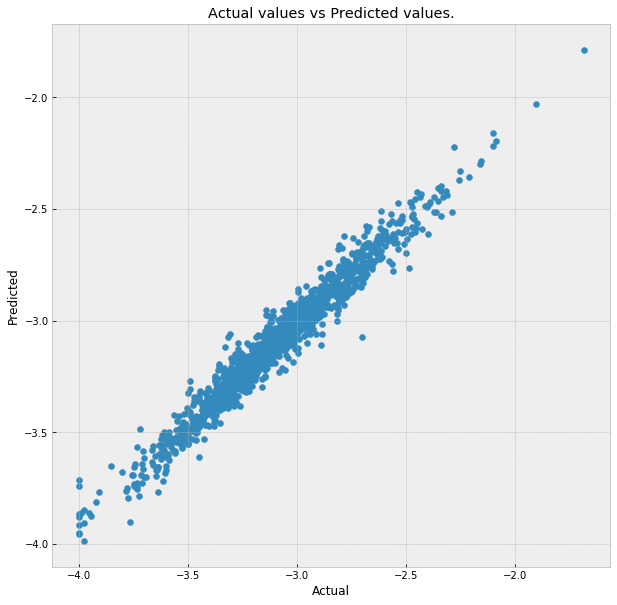

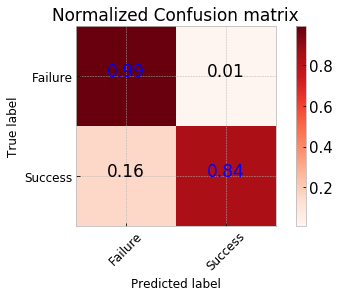

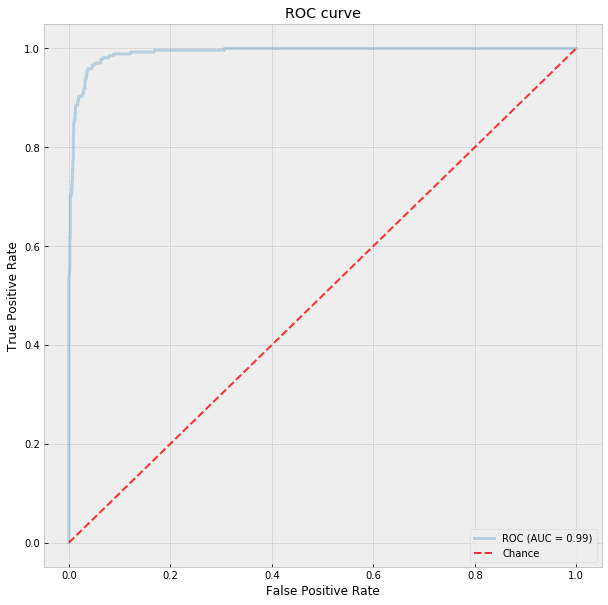

rmse: 0.065
explained_variance: 0.955
r_2: 0.955
accuracy: 0.963
tpr: 0.844
specificity: 0.991
fpr: 0.009
ppv: 0.954
npv: 0.965
f_score: 0.895
auc: 0.992


{'rmse': 0.06533926030048233,
 'explained_variance': 0.955498241465865,
 'r_2': 0.9554968285123859,
 'accuracy': 0.9631432545201669,
 'tpr': 0.8438661710037175,
 'specificity': 0.9905902480752781,
 'fpr': 0.009409751924721984,
 'ppv': 0.9537815126050421,
 'npv': 0.965,
 'f_score': 0.8954635108481263,
 'auc': 0.9918829361987654}

In [105]:
evaluate_model(model_lgb, X_train, y_train, training=True)

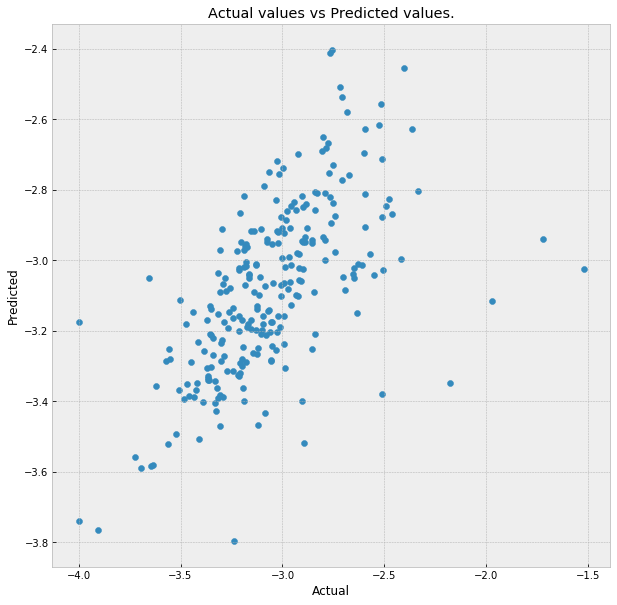

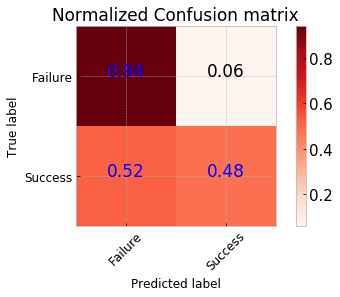

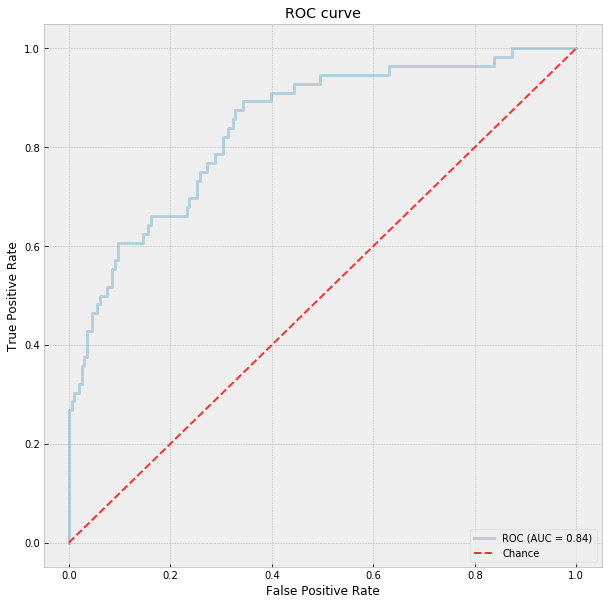

rmse: 0.268
explained_variance: 0.357
r_2: 0.350
accuracy: 0.839
tpr: 0.482
specificity: 0.939
fpr: 0.061
ppv: 0.692
npv: 0.865
f_score: 0.568
auc: 0.843


{'rmse': 0.26762501645596176,
 'explained_variance': 0.35664798120473207,
 'r_2': 0.3495872096085678,
 'accuracy': 0.8385826771653543,
 'tpr': 0.48214285714285715,
 'specificity': 0.9393939393939394,
 'fpr': 0.06060606060606061,
 'ppv': 0.6923076923076923,
 'npv': 0.8651162790697674,
 'f_score': 0.5684210526315789,
 'auc': 0.8426226551226551}

In [106]:
evaluate_model(model_lgb, X_test, y_test, training=False)

In [ ]:
for model in models:
    evaluate_train_test(model, X_train, y_train, X_test, y_test)
    print()

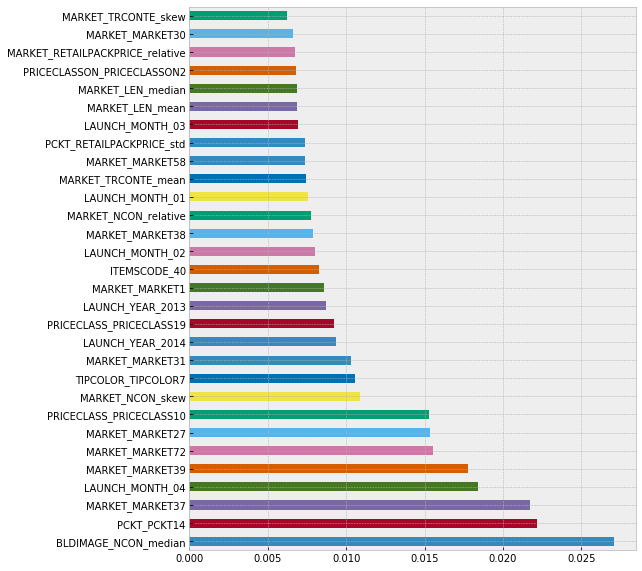

In [25]:
feat_imp = pd.Series(model_extratree.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

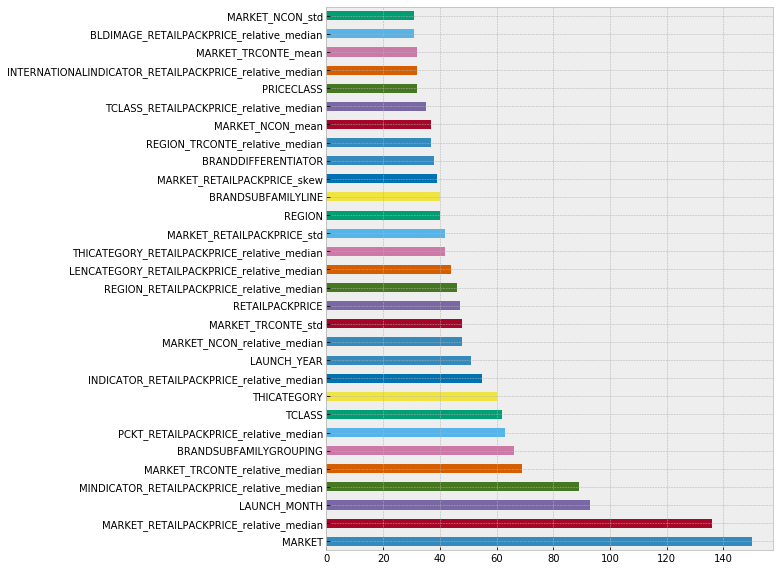

In [107]:
feat_imp = pd.Series(model_lgb.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [ ]:
feat_imp = pd.Series(model_xgb.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10));

In [231]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [239]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_split_gain': '{:.4f}'.format(params['min_split_gain']),
        'drop_rate': '{:.4f}'.format(params['drop_rate'])
        
    }

    regressor = lgb.LGBMRegressor(
    boosting_type='dart',
    
    objective='rmse',
    n_estimators=5000,
    learning_rate=0.3,
    
#     max_depth=4,             # Specify the max depth to which tree will grow. 
#     num_leaves=10,             # Number of leaves in one tree

    min_child_weight=11,     # minimal sum hessian in one leaf
    min_data_in_leaf=20,       # Min number of data in one leaf.
    
    subsample=0.75,            # Specifies the fraction of data to be used for each iteration
    subsample_freq=5,
    bagging_seed=9,
    
#     colsample_bytree=0.45,  # Specifies the fraction of features to be taken for each iteration
    feature_fraction_seed=7,
    
#     min_gain_to_split=0.002,    # Min gain to perform splitting
    reg_alpha=0.001,
    reg_lambda=0.,
#     max_bin=55,
#     drop_rate=0.3,
    max_drop=50,
    
    n_jobs=2,
    **params
    )

    score = cv(regressor, X_train, y_train)
    
    print()
    print(params)
    print(score)
    return float(score.splitlines()[3].split()[-4])


space = {
    'max_depth': hp.quniform('max_depth', 4, 6, 1),
    'num_leaves': hp.quniform('num_leaves', 16, 64, 8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.8),
    'min_split_gain': hp.uniform('min_split_gain', 0.0018, 0.0022),
    'drop_rate': hp.quniform('drop_rate', 0.2, 0.4, 0.05),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.037 │            0.271 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.327 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.324 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.816 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.944 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.994 │            0.930 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.006 │            0.070 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.039 │            0.268 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.984 │            0.341 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.984 │            0.339 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.812 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.949 │            0.377 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.993 │            0.930 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.007 │            0.070 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.038 │            0.270 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.985 │            0.330 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.985 │            0.329 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.986 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.949 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.995 │            0.916 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.005 │            0.084 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.067 │            0.275 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.983 │            0.318 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.953 │            0.303 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.970 │            0.795 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.995 │            0.426 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.964 │            0.894 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.036 │            0.106 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.036 │            0.277 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.296 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.295 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.985 │            0.806 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.953 │            0.377 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.993 │            0.921 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.007 │            0.079 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.047 │            0.275 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.982 │            0.302 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.977 │            0.301 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.983 │            0.795 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.977 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.985 │            0.903 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.015 │            0.097 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.039 │            0.276 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.984 │            0.299 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.984 │            0.297 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.983 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.930 │            0.377 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.995 │            0.912 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.005 │            0.088 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.036 │            0.271 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.987 │            0.326 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.987 │            0.325 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.983 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.940 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.993 │            0.916 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.007 │            0.084 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.036 │            0.272 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.987 │            0.322 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.987 │            0.320 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.986 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.949 │            0.344 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.995 │            0.921 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.005 │            0.079 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.037 │            0.272 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.321 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.319 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.987 │            0.809 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.949 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.996 │            0.930 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.004 │            0.070 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.036 │            0.269 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.335 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.333 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.983 │            0.812 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.940 │            0.410 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.994 │            0.921 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.006 │            0.079 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.039 │            0.273 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.984 │            0.318 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.984 │            0.316 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.981 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.930 │            0.344 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.993 │            0.921 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.007 │            0.079 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.036 │            0.278 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.987 │            0.290 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.987 │            0.289 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.940 │            0.377 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.995 │            0.912 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.005 │            0.088 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.035 │            0.272 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.987 │            0.318 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.987 │            0.316 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.953 │            0.377 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.991 │            0.912 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.009 │            0.088 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.035 │            0.273 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.987 │            0.317 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.987 │            0.315 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.809 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.940 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.995 │            0.921 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.005 │            0.079 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.049 │            0.275 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.305 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.975 │            0.302 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.795 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.991 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.983 │            0.903 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.017 │            0.097 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.039 │            0.276 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.984 │            0.301 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.984 │            0.301 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.812 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.944 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.994 │            0.925 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.006 │            0.075 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.048 │            0.273 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.984 │            0.314 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.976 │            0.312 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.981 │            0.410 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.985 │            0.903 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.015 │            0.097 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.036 │            0.276 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.301 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.300 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.989 │            0.799 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.958 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.996 │            0.916 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.004 │            0.084 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.039 │            0.273 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.984 │            0.318 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.984 │            0.316 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.823 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.953 │            0.410 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.991 │            0.934 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.009 │            0.066 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.038 │            0.269 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.985 │            0.334 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.985 │            0.332 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.985 │            0.806 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.949 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.994 │            0.925 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.006 │            0.075 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.036 │            0.272 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.319 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.318 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.988 │            0.809 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.958 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.995 │            0.930 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.005 │            0.070 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.037 │            0.274 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.312 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.311 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.986 │            0.806 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.953 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.994 │            0.925 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.006 │            0.075 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.038 │            0.276 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.985 │            0.299 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.985 │            0.298 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.982 │            0.795 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.944 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.990 │            0.912 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.010 │            0.088 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.037 │            0.272 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.320 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.319 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.983 │            0.809 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.935 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.994 │            0.930 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.006 │            0.070 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.037 │            0.273 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.315 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.314 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.985 │            0.812 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.944 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.995 │            0.925 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.005 │            0.075 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.037 │            0.272 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.322 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.986 │            0.320 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.984 │            0.819 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.949 │            0.377 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.993 │            0.938 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.007 │            0.062 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.052 │            0.270 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.986 │            0.334 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.972 │            0.331 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.981 │            0.792 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.986 │            0.393 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.980 │            0.899 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.020 │            0.101 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.036 │            0.275 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.987 │            0.306 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.987 │            0.305 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.983 │            0.812 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.940 │            0.377 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.993 │            0.930 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.007 │            0.070 │
├────────────────────┼────────────────┼───────


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.035 │            0.278 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.987 │            0.291 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.987 │            0.288 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.986 │            0.806 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.953 │            0.361 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.994 │            0.925 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.006 │            0.075 │
├────────────────────┼────────────────┼───────

In [230]:
float(score.splitlines()[3].split()[-4])

0.252

In [240]:
best

{'colsample_bytree': 0.6648798701006267,
 'drop_rate': 0.35000000000000003,
 'max_depth': 5.0,
 'min_split_gain': 0.0019209666600232818,
 'num_leaves': 24.0}

In [ ]:
best['num_leaves'] = 128